# Power Anomaly Detection for Mars Curiosity Rover

**Course**: CSCA 5622 - Supervised Learning  
**Author**: Roman Di Domizio  
**Date**: December 2025

---

## Overview

This notebook develops a **supervised binary classification model** to detect power subsystem anomalies in NASA's Mars Curiosity Rover telemetry data. The model classifies sliding windows of power readings as either normal or anomalous.

### What This Notebook Does
1. **Loads** real telemetry data from NASA's Curiosity Rover power subsystem (Channel P-10)
2. **Cleans** the data by checking for missing values, outliers, and data quality issues
3. **Explores** the data through visualizations of class distribution, time series, and autocorrelation
4. **Engineers features** using sliding windows over the power telemetry stream (23 features per window)
5. **Trains and compares** 5 supervised learning models from ISLP Chapters 4, 8, and 9
6. **Tunes** the decision threshold for optimal anomaly detection
7. **Evaluates** performance on a held-out test set

### Data
- **Source**: NASA Mars Science Laboratory (Curiosity Rover) telemetry
- **Channel**: P-10 (Power subsystem)
- **Size**: 6,100 timesteps with expert-annotated anomaly labels

### Methods
- Logistic Regression (ISLP Chapter 4)
- Support Vector Machines with RBF kernel (ISLP Chapter 9)
- Random Forest and Gradient Boosting (ISLP Chapter 8)

### Primary Metric
- **PR-AUC** (Precision-Recall Area Under Curve) — appropriate for the ~2% anomaly rate

### Reference
Hundman, K., et al. "Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding." KDD 2018.

**GitHub Repository**: https://github.com/romandidomizio/space-autonomy/tree/main/AegisNav-Anomaly-Detection

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Scipy for signal processing
from scipy import signal, stats
from scipy.fft import fft, fftfreq

# Scikit-learn imports (ISLP Ch 4, 8, 9 methods)
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, average_precision_score, 
    precision_recall_curve, roc_curve,
    auc, make_scorer
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
import joblib

# Plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Project paths
PROJECT_ROOT = Path.cwd()  # Assumes notebook is run from project directory
DATA_DIR = PROJECT_ROOT / 'data'
MODEL_DIR = PROJECT_ROOT / 'models'
DATA_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

print(f"✓ Setup complete")
print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ Random state: {RANDOM_STATE}")

✓ Setup complete
✓ Project root: /Users/romandidomizio/MSAI-Notes/CSCA5622/module7_final_project/AegisNav-Anomaly-Detection
✓ Random state: 42


---
## 1. Problem Framing

### The Challenge
NASA's Curiosity Rover has been operating on Mars since 2012. With communication delays of 4-24 minutes between Earth and Mars, real-time human intervention is impossible. The rover must detect anomalies autonomously to protect itself from failures.

### Task Definition
**Binary classification**: Given a window of power telemetry data, predict whether it contains an anomaly (1) or is normal (0).

### Inputs and Outputs
- **Input (X)**: Engineered features extracted from sliding windows over the P-10 power channel
- **Output (y)**: Binary label — 1 if the window overlaps any expert-labeled anomaly, 0 otherwise

### Why Power Subsystem (P-10)?
The power subsystem is critical for Mars rover survival:
- **No power = mission over** — unlike other subsystems, power failure is catastrophic
- Solar panels, batteries, and power distribution must work continuously
- Mars dust storms can reduce solar input by 99%
- Nighttime temperatures (-125°C) stress batteries

### Evaluation Strategy
- **Primary Metric**: PR-AUC (Precision-Recall Area Under Curve) — handles the ~2% anomaly rate
- **Secondary Metrics**: ROC-AUC, recall (sensitivity), precision
- **Operational Goal**: High recall (catch anomalies) with acceptable precision (limit false alarms)

### Data Splitting
- **Time-based splits** to simulate real-world deployment
- Train on earlier mission data, test on later data
- Prevents data leakage from future to past

---
## 2. Data Acquisition

### 2.1 Data Loading

**Dataset**: NASA Mars Science Laboratory (MSL) — Curiosity Rover Telemetry

**What is MSL/Curiosity?**
The Mars Science Laboratory mission launched in 2011 and landed Curiosity Rover on Mars in August 2012. Curiosity is a car-sized rover designed to explore Gale Crater and assess whether Mars ever had conditions favorable for microbial life. It continues to operate today, having traveled over 30 km on Mars.

**Original Source**: 
- Hundman et al., KDD 2018: "Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding"
- Kaggle mirror: `patrickfleith/nasa-anomaly-detection-dataset-smap-msl`
- Original telemetry collected and labeled by NASA Jet Propulsion Laboratory (JPL)

**Channel Selected**: P-10 (Power Subsystem)
| Attribute | Value |
|-----------|-------|
| Channel ID | P-10 |
| Subsystem | Power |
| Samples | 6,100 timesteps |
| Anomaly segments | 1 |
| Anomaly rate | ~2.1% |

**Why P-10?**
- Largest MSL channel (6,100 samples) — enables robust model training
- Power is the most critical subsystem for rover survival
- Realistic anomaly rate (~2%) demonstrates real-world class imbalance
- Single channel allows focused analysis without multi-channel complexity

**Data Format**:
- `.npy` file containing 2D array: `(timesteps, features)`
- First column = actual power telemetry value (pre-scaled to [-1, 1])
- Remaining columns = one-hot encoded command information (not used)
- Labels from `labeled_anomalies.csv` specify anomaly segment indices

In [2]:
# =============================================================================
# LOAD NASA MSL (CURIOSITY ROVER) TELEMETRY DATA
# =============================================================================

def load_msl_channel(data_dir, channel_id='P-10'):
    """
    Load a single MSL (Mars Curiosity Rover) telemetry channel.
    
    Args:
        data_dir: Path to data directory containing test/, labeled_anomalies.csv
        channel_id: Channel to load (default: 'P-10' for power subsystem)
    
    Returns:
        telemetry_df: DataFrame with single telemetry column
        labels_df: DataFrame with binary anomaly labels per timestep
        anomaly_segments: List of dicts with anomaly segment info
        channel_info: Dict with metadata about the channel
    """
    import ast
    data_dir = Path(data_dir)
    
    # Load anomaly labels CSV
    labels_csv = pd.read_csv(data_dir / 'labeled_anomalies.csv')
    
    # Filter for MSL spacecraft and specific channel
    channel_row = labels_csv[
        (labels_csv['spacecraft'] == 'MSL') & 
        (labels_csv['chan_id'] == channel_id)
    ]
    
    if len(channel_row) == 0:
        raise ValueError(f"Channel {channel_id} not found in MSL data")
    
    channel_row = channel_row.iloc[0]
    
    # Load test data (where anomaly labels exist)
    test_path = data_dir / 'test' / f'{channel_id}.npy'
    if not test_path.exists():
        raise FileNotFoundError(f"Data file not found: {test_path}")
    
    test_data = np.load(test_path)
    telemetry_values = test_data[:, 0]  # First column is telemetry
    n_samples = len(telemetry_values)
    
    print(f"Loading MSL Channel: {channel_id}")
    print(f"  Spacecraft: Mars Science Laboratory (Curiosity Rover)")
    print(f"  Subsystem: Power")
    print(f"  Samples: {n_samples:,}")
    
    # Parse anomaly sequences
    try:
        sequences = ast.literal_eval(channel_row['anomaly_sequences'])
    except:
        sequences = []
    
    # Create binary labels array
    binary_labels = np.zeros(n_samples, dtype=int)
    anomaly_segments = []
    
    for seq in sequences:
        start, end = seq
        binary_labels[start:end+1] = 1
        anomaly_segments.append({
            'channel': channel_id,
            'start': start,
            'end': end,
            'length': end - start + 1
        })
    
    anomaly_rate = binary_labels.mean()
    print(f"  Anomaly segments: {len(sequences)}")
    print(f"  Anomaly rate: {anomaly_rate*100:.2f}%")
    
    # Create DataFrames
    telemetry_df = pd.DataFrame({channel_id: telemetry_values})
    labels_df = pd.DataFrame({'label': binary_labels})
    
    channel_info = {
        'channel_id': channel_id,
        'spacecraft': 'MSL',
        'subsystem': 'Power',
        'n_samples': n_samples,
        'n_segments': len(sequences),
        'anomaly_rate': anomaly_rate,
        'anomaly_timesteps': binary_labels.sum()
    }
    
    return telemetry_df, labels_df, anomaly_segments, channel_info


# =============================================================================
# LOAD MSL P-10 POWER CHANNEL
# =============================================================================

print("="*60)
print("LOADING NASA MSL (CURIOSITY ROVER) TELEMETRY DATA")
print("="*60)
print("Mission: Mars Science Laboratory")
print("Rover: Curiosity")
print("Landing: August 6, 2012 - Gale Crater, Mars")
print("Data Source: Hundman et al. KDD 2018 (NASA JPL)")
print("="*60 + "\n")

# Load the P-10 power channel
telemetry_df, labels_df, anomaly_segments, channel_info = load_msl_channel(
    data_dir=DATA_DIR,
    channel_id='P-10'
)

print(f"\n✓ Loaded MSL Power Channel (P-10)")
print(f"✓ Total timesteps: {len(telemetry_df):,}")
print(f"✓ Anomaly segments: {len(anomaly_segments)}")
print(f"✓ Anomaly rate: {channel_info['anomaly_rate']:.2%}")
print(f"✓ Anomalous timesteps: {channel_info['anomaly_timesteps']:,}")

print("\nData shape:", telemetry_df.shape)
print("Labels shape:", labels_df.shape)
print("\nFirst few rows:")
telemetry_df.head()

LOADING NASA MSL (CURIOSITY ROVER) TELEMETRY DATA
Mission: Mars Science Laboratory
Rover: Curiosity
Landing: August 6, 2012 - Gale Crater, Mars
Data Source: Hundman et al. KDD 2018 (NASA JPL)

Loading MSL Channel: P-10
  Spacecraft: Mars Science Laboratory (Curiosity Rover)
  Subsystem: Power
  Samples: 6,100
  Anomaly segments: 1
  Anomaly rate: 2.15%

✓ Loaded MSL Power Channel (P-10)
✓ Total timesteps: 6,100
✓ Anomaly segments: 1
✓ Anomaly rate: 2.15%
✓ Anomalous timesteps: 131

Data shape: (6100, 1)
Labels shape: (6100, 1)

First few rows:


,P-10
0,0.992941
1,0.993788
2,0.993788
3,0.994635
4,0.994635


### 2.2 Data Cleaning

**Why Data Cleaning Matters for Spacecraft Telemetry**:
Even professionally curated NASA datasets can have issues from transmission errors, sensor glitches, or data processing artifacts. We perform comprehensive quality checks before modeling.

**Checks Performed**:
1. **Missing Values** — Sensor dropouts or transmission errors from Mars-to-Earth communication
2. **Infinite Values** — Calculation errors or sensor saturation
3. **Value Ranges** — Verify data is within expected normalized bounds [-1, 1]
4. **Low Variance** — Check if sensor readings are stuck or non-informative
5. **Duplicate Rows** — Repeated measurements from sensor lag
6. **Outliers** — Extreme values that may indicate anomalies (NOT removed)
7. **Label Distribution** — Assess class imbalance for model selection

**Cleaning Actions**:
- Fill missing values with forward-fill/backward-fill (if any exist)
- Replace infinite values with interpolated values (if any exist)
- Create outlier flag feature (outliers may BE the anomalies we want to detect)
- Document all findings for reproducibility

In [3]:
# =============================================================================
# DATA CLEANING - Quality Assessment and Transformations
# =============================================================================

print("="*60)
print("DATA QUALITY ASSESSMENT AND CLEANING")
print("="*60)
print(f"Channel: {channel_info['channel_id']} (Power Subsystem)")
print("="*60)

# Track what cleaning actions we take
cleaning_actions = []
channel = telemetry_df.columns[0]  # P-10

# -----------------------------------------------------------------------------
# 1. MISSING VALUES CHECK AND FIX
# -----------------------------------------------------------------------------
print("\n1. MISSING VALUES CHECK")
print("-" * 40)
missing_count = telemetry_df[channel].isnull().sum()
print(f"Missing values in {channel}: {missing_count} ({missing_count/len(telemetry_df)*100:.2f}%)")

if missing_count > 0:
    telemetry_df = telemetry_df.fillna(method='ffill').fillna(method='bfill')
    cleaning_actions.append(f"Filled {missing_count} missing values using forward/backward fill")
    print(f"  → Applied forward-fill and backward-fill")
    print(f"  ✓ Missing values after cleaning: {telemetry_df[channel].isnull().sum()}")
else:
    print("  ✓ No missing values detected")

# -----------------------------------------------------------------------------
# 2. INFINITE VALUES CHECK AND FIX
# -----------------------------------------------------------------------------
print("\n2. INFINITE VALUES CHECK")
print("-" * 40)
inf_count = np.isinf(telemetry_df[channel].values).sum()
print(f"Infinite values in {channel}: {inf_count}")

if inf_count > 0:
    telemetry_df = telemetry_df.replace([np.inf, -np.inf], np.nan)
    telemetry_df = telemetry_df.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    cleaning_actions.append(f"Replaced {inf_count} infinite values with interpolated values")
    print(f"  → Replaced with interpolated values")
else:
    print("  ✓ No infinite values detected")

# -----------------------------------------------------------------------------
# 3. VALUE RANGE CHECK
# -----------------------------------------------------------------------------
print("\n3. VALUE RANGE CHECK")
print("-" * 40)
col_min = telemetry_df[channel].min()
col_max = telemetry_df[channel].max()
print(f"{channel}: [{col_min:.4f}, {col_max:.4f}]", end="")

if col_min < -1.0 or col_max > 1.0:
    # Re-normalize if needed
    telemetry_df[channel] = 2 * (telemetry_df[channel] - col_min) / (col_max - col_min) - 1
    cleaning_actions.append(f"Re-normalized {channel} to [-1, 1] range")
    print(" → Re-normalized to [-1, 1]")
else:
    print(" ✓ Within expected range")

# -----------------------------------------------------------------------------
# 4. VARIANCE CHECK
# -----------------------------------------------------------------------------
print("\n4. VARIANCE CHECK")
print("-" * 40)
variance = telemetry_df[channel].var()
print(f"{channel} variance: {variance:.6f}")

if variance < 1e-10:
    print("  ⚠ WARNING: Very low variance - sensor may be stuck")
else:
    print("  ✓ Sufficient variance for modeling")

# -----------------------------------------------------------------------------
# 5. DUPLICATE ROWS CHECK
# -----------------------------------------------------------------------------
print("\n5. DUPLICATE ROWS CHECK")
print("-" * 40)
n_duplicates = telemetry_df.duplicated().sum()
print(f"Duplicate rows: {n_duplicates} ({n_duplicates/len(telemetry_df)*100:.2f}%)")
if n_duplicates > 0:
    print("  Note: Duplicates KEPT - valid repeated sensor readings in telemetry")

# -----------------------------------------------------------------------------
# 6. OUTLIER DETECTION AND FEATURE CREATION
# -----------------------------------------------------------------------------
print("\n6. OUTLIER DETECTION (IQR Method)")
print("-" * 40)
Q1 = telemetry_df[channel].quantile(0.25)
Q3 = telemetry_df[channel].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

is_outlier = (telemetry_df[channel] < lower_bound) | (telemetry_df[channel] > upper_bound)
n_outliers = is_outlier.sum()
print(f"{channel}: {n_outliers:,} extreme outliers ({n_outliers/len(telemetry_df)*100:.2f}%)")
print(f"  IQR bounds: [{lower_bound:.4f}, {upper_bound:.4f}]")

# Create outlier flag as additional feature
telemetry_df['is_outlier'] = is_outlier.astype(int)
cleaning_actions.append("Created 'is_outlier' binary feature flag")
print("  → Created 'is_outlier' feature (may help detect anomalies)")
print("  → Outliers NOT removed (may represent true anomalies)")

# -----------------------------------------------------------------------------
# 7. LABEL DISTRIBUTION CHECK
# -----------------------------------------------------------------------------
print("\n7. LABEL DISTRIBUTION CHECK")
print("-" * 40)
label_counts = labels_df['label'].value_counts().sort_index()
n_normal = label_counts.get(0, 0)
n_anomaly = label_counts.get(1, 0)
print(f"  Normal (0): {n_normal:,} ({n_normal/len(labels_df)*100:.2f}%)")
print(f"  Anomaly (1): {n_anomaly:,} ({n_anomaly/len(labels_df)*100:.2f}%)")
imbalance_ratio = n_normal / max(n_anomaly, 1)
print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")

if imbalance_ratio > 10:
    print("  ⚠ Significant class imbalance - will use PR-AUC metric and balanced class weights")

# -----------------------------------------------------------------------------
# CLEANING SUMMARY
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("DATA CLEANING SUMMARY")
print("="*60)
print(f"Channel: {channel_info['channel_id']}")
print(f"Final shape: {telemetry_df.shape}")

if len(cleaning_actions) > 0:
    print(f"\nCleaning actions performed ({len(cleaning_actions)}):")
    for i, action in enumerate(cleaning_actions, 1):
        print(f"  {i}. {action}")
else:
    print("\nNo cleaning actions needed - data was already clean.")

print("\n✓ Data ready for feature engineering")

DATA QUALITY ASSESSMENT AND CLEANING
Channel: P-10 (Power Subsystem)

1. MISSING VALUES CHECK
----------------------------------------
Missing values in P-10: 0 (0.00%)
  ✓ No missing values detected

2. INFINITE VALUES CHECK
----------------------------------------
Infinite values in P-10: 0
  ✓ No infinite values detected

3. VALUE RANGE CHECK
----------------------------------------
P-10: [-1.0000, 1.0000] ✓ Within expected range

4. VARIANCE CHECK
----------------------------------------
P-10 variance: 0.512357
  ✓ Sufficient variance for modeling

5. DUPLICATE ROWS CHECK
----------------------------------------
Duplicate rows: 5489 (89.98%)
  Note: Duplicates KEPT - valid repeated sensor readings in telemetry

6. OUTLIER DETECTION (IQR Method)
----------------------------------------
P-10: 1,483 extreme outliers (24.31%)
  IQR bounds: [0.9842, 1.0020]
  → Created 'is_outlier' feature (may help detect anomalies)
  → Outliers NOT removed (may represent true anomalies)

7. LABEL DIST

---
## 3. Exploratory Data Analysis

**EDA Goals for MSL P-10 Power Channel**:
1. Understand the ~2% anomaly rate and class imbalance
2. Visualize power telemetry patterns and anomaly characteristics
3. Check autocorrelation to determine optimal window size
4. Examine signal stationarity and trends
5. Identify patterns that distinguish normal vs anomalous behavior

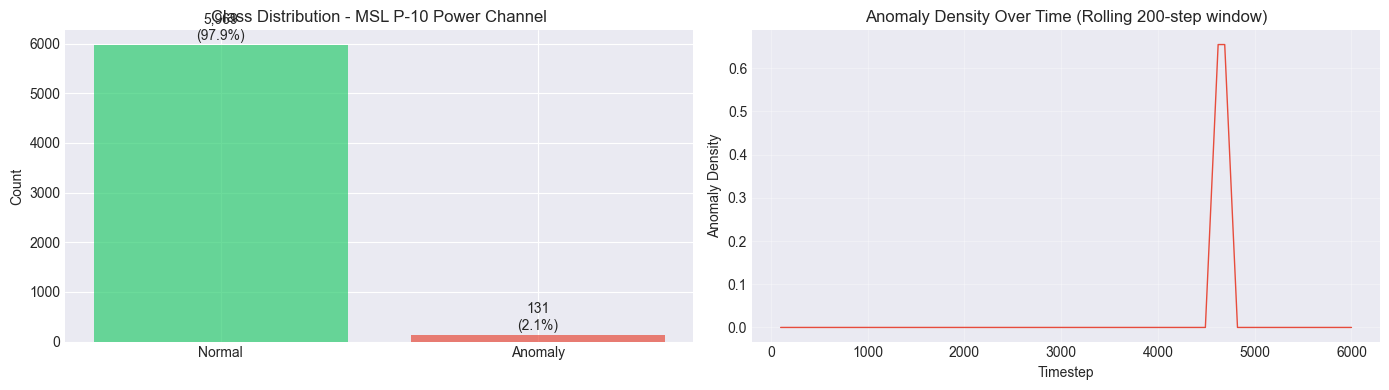

Class Imbalance Ratio: 45.6:1 (Normal:Anomaly)
Baseline accuracy (always predict normal): 97.85%

Note: With ~131 anomalous samples, we have enough data to train models,
but the imbalance requires careful metric selection (PR-AUC over accuracy).


In [4]:
# 3.1 Class Imbalance Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Bar plot of class distribution
class_counts = labels_df['label'].value_counts().sort_index()
axes[0].bar(['Normal', 'Anomaly'], [class_counts[0], class_counts[1]], 
            color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution - MSL P-10 Power Channel')
for i, v in enumerate([class_counts[0], class_counts[1]]):
    axes[0].text(i, v + 50, f'{v:,}\n({v/len(labels_df)*100:.1f}%)', ha='center', va='bottom')

# Time series of anomaly density
window_size = 200
anomaly_density = labels_df['label'].rolling(window=window_size, center=True).mean()
axes[1].plot(anomaly_density, color='#e74c3c', linewidth=1)
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Anomaly Density')
axes[1].set_title(f'Anomaly Density Over Time (Rolling {window_size}-step window)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Class Imbalance Ratio: {class_counts[0]/class_counts[1]:.1f}:1 (Normal:Anomaly)")
print(f"Baseline accuracy (always predict normal): {(1 - labels_df['label'].mean())*100:.2f}%")
print(f"\nNote: With ~{class_counts[1]} anomalous samples, we have enough data to train models,"
      f"\nbut the imbalance requires careful metric selection (PR-AUC over accuracy).")

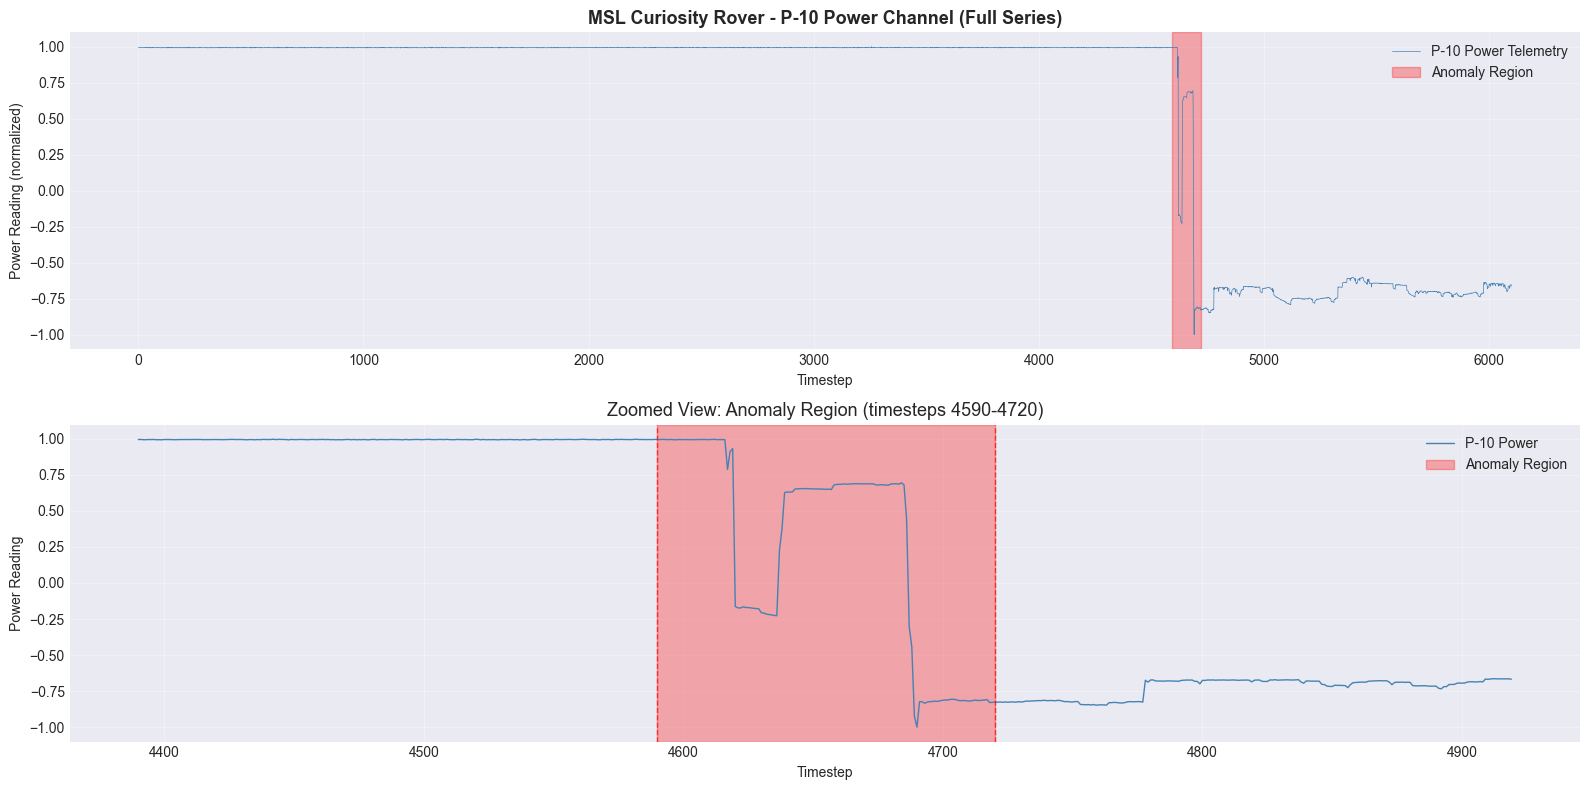

Anomaly Segments in P-10 Power Channel:
  • Timesteps 4590 to 4720 (131 samples)


In [5]:
# 3.2 Time Series Visualization with Anomaly Regions
channel = telemetry_df.columns[0]  # P-10

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Full time series
ax = axes[0]
ax.plot(telemetry_df[channel].values, linewidth=0.5, color='steelblue', label='P-10 Power Telemetry')

# Shade anomaly regions
anomaly_mask = labels_df['label'].values
anomaly_starts = np.where(np.diff(np.concatenate([[0], anomaly_mask])) == 1)[0]
anomaly_ends = np.where(np.diff(np.concatenate([anomaly_mask, [0]])) == -1)[0]

for i, (start, end) in enumerate(zip(anomaly_starts, anomaly_ends)):
    ax.axvspan(start, end, alpha=0.3, color='red', label='Anomaly Region' if i == 0 else '')

ax.set_xlabel('Timestep')
ax.set_ylabel('Power Reading (normalized)')
ax.set_title('MSL Curiosity Rover - P-10 Power Channel (Full Series)', fontsize=13, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

# Zoomed view around anomaly region
ax2 = axes[1]
if len(anomaly_starts) > 0:
    # Zoom around the first anomaly with context
    anomaly_start = anomaly_starts[0]
    anomaly_end = anomaly_ends[0]
    context = 200  # Show 200 timesteps before and after
    zoom_start = max(0, anomaly_start - context)
    zoom_end = min(len(telemetry_df), anomaly_end + context)
    
    zoom_range = range(zoom_start, zoom_end)
    ax2.plot(zoom_range, telemetry_df[channel].iloc[zoom_start:zoom_end].values, 
             linewidth=1, color='steelblue', label='P-10 Power')
    ax2.axvspan(anomaly_start, anomaly_end, alpha=0.3, color='red', label='Anomaly Region')
    ax2.axvline(anomaly_start, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax2.axvline(anomaly_end, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Power Reading')
    ax2.set_title(f'Zoomed View: Anomaly Region (timesteps {anomaly_start}-{anomaly_end})', fontsize=13)
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print anomaly segment details
print("Anomaly Segments in P-10 Power Channel:")
for seg in anomaly_segments:
    print(f"  • Timesteps {seg['start']} to {seg['end']} ({seg['length']} samples)")

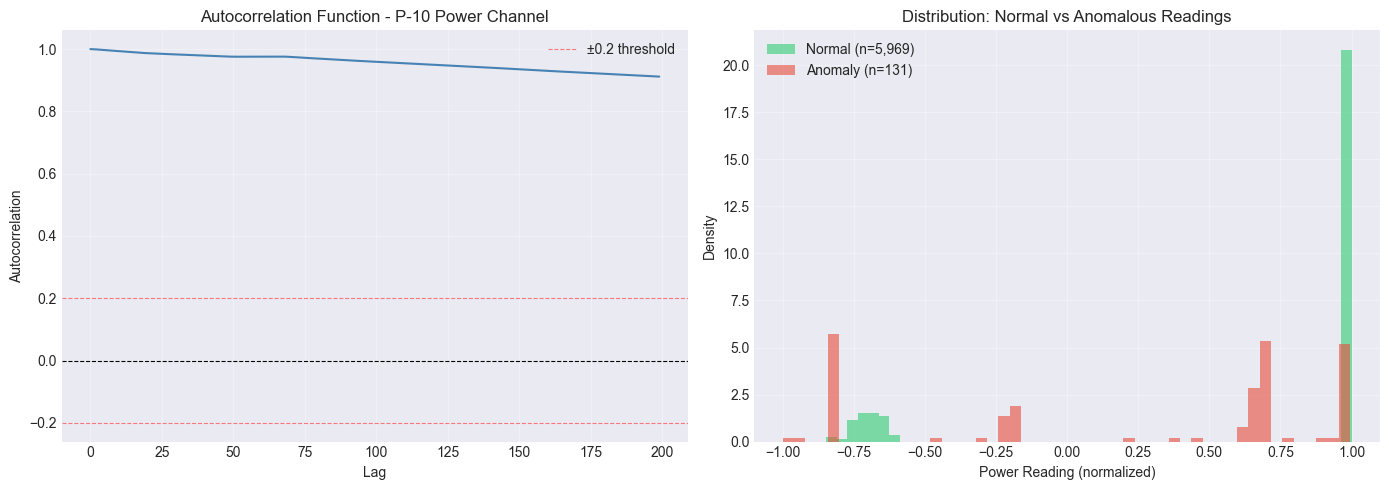

ACF Analysis:
  • Autocorrelation remains high (>0.2) throughout 200 lags
  • Recommended window size: 50-100 timesteps (conservative)

Normal vs Anomaly Statistics:
  Statistic             Normal      Anomaly
  ----------------------------------------
  Mean                  0.6028       0.2407
  Std                   0.7140       0.7108
  Min                  -0.8475      -1.0000
  Max                   1.0000       0.9958


In [6]:
# 3.3 Autocorrelation Analysis and Signal Statistics
channel = telemetry_df.columns[0]  # P-10

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Autocorrelation function
ax = axes[0]
lags = range(0, 200)
acf_values = [telemetry_df[channel].autocorr(lag=lag) for lag in lags]
ax.plot(lags, acf_values, linewidth=1.5, color='steelblue')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
ax.axhline(y=0.2, color='r', linestyle='--', linewidth=0.8, alpha=0.5, label='±0.2 threshold')
ax.axhline(y=-0.2, color='r', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title(f'Autocorrelation Function - {channel} Power Channel')
ax.legend()
ax.grid(alpha=0.3)

# Distribution comparison: Normal vs Anomaly
ax2 = axes[1]
normal_values = telemetry_df[channel][labels_df['label'] == 0]
anomaly_values = telemetry_df[channel][labels_df['label'] == 1]

ax2.hist(normal_values, bins=50, alpha=0.6, label=f'Normal (n={len(normal_values):,})', color='#2ecc71', density=True)
ax2.hist(anomaly_values, bins=50, alpha=0.6, label=f'Anomaly (n={len(anomaly_values):,})', color='#e74c3c', density=True)
ax2.set_xlabel('Power Reading (normalized)')
ax2.set_ylabel('Density')
ax2.set_title('Distribution: Normal vs Anomalous Readings')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ACF Analysis
print("ACF Analysis:")
below_threshold = np.where(np.array(acf_values) < 0.2)[0]
if len(below_threshold) > 0:
    lag_threshold = below_threshold[0]
    print(f"  • Significant autocorrelation persists up to ~{lag_threshold} lags")
    print(f"  • Recommended window size: {max(50, lag_threshold)} timesteps")
else:
    print(f"  • Autocorrelation remains high (>0.2) throughout {len(acf_values)} lags")
    print(f"  • Recommended window size: 50-100 timesteps (conservative)")

# Statistical comparison
print("\nNormal vs Anomaly Statistics:")
print(f"  {'Statistic':<15} {'Normal':>12} {'Anomaly':>12}")
print(f"  {'-'*40}")
print(f"  {'Mean':<15} {normal_values.mean():>12.4f} {anomaly_values.mean():>12.4f}")
print(f"  {'Std':<15} {normal_values.std():>12.4f} {anomaly_values.std():>12.4f}")
print(f"  {'Min':<15} {normal_values.min():>12.4f} {anomaly_values.min():>12.4f}")
print(f"  {'Max':<15} {normal_values.max():>12.4f} {anomaly_values.max():>12.4f}")

---
## 4. Feature Engineering

**Windowing Strategy for P-10 Power Channel**:
- **Window size**: 50 timesteps (based on ACF analysis and dataset size)
- **Stride**: 5 timesteps (90% overlap for dense predictions)
- **Label assignment**: Window labeled as anomaly if any timestep overlaps with anomaly segment

**Feature Types** (22 features per window):
1. **Statistical**: mean, std, min, max, median, IQR, range
2. **Temporal**: first-last delta, slope (linear fit), lag-1 autocorrelation
3. **Distribution**: skewness, kurtosis, quantiles (25%, 75%)
4. **Spectral**: Energy in low/mid/high frequency bands (FFT-based)
5. **Derivative**: Mean and std of first differences
6. **Outlier**: Sum of outlier flags within window

All features are computed **within each window** to avoid data leakage from global statistics.

In [7]:
def extract_window_features(window_data, outlier_flags=None):
    """
    Extract comprehensive features from a single window of power telemetry data.
    
    Args:
        window_data: 1D numpy array of telemetry values
        outlier_flags: Optional 1D numpy array of outlier flags (0/1)
        
    Returns:
        dict of feature_name: feature_value
    """
    features = {}
    
    # Statistical features
    features['mean'] = np.mean(window_data)
    features['std'] = np.std(window_data)
    features['min'] = np.min(window_data)
    features['max'] = np.max(window_data)
    features['median'] = np.median(window_data)
    features['range'] = features['max'] - features['min']
    
    # Quantiles and IQR
    q25, q75 = np.percentile(window_data, [25, 75])
    features['q25'] = q25
    features['q75'] = q75
    features['iqr'] = q75 - q25
    
    # Distribution shape
    features['skewness'] = stats.skew(window_data)
    features['kurtosis'] = stats.kurtosis(window_data)
    
    # Temporal features
    features['first_value'] = window_data[0]
    features['last_value'] = window_data[-1]
    features['first_last_delta'] = window_data[-1] - window_data[0]
    
    # Linear trend (slope)
    x = np.arange(len(window_data))
    if len(window_data) > 1:
        slope, _ = np.polyfit(x, window_data, 1)
        features['slope'] = slope
    else:
        features['slope'] = 0
    
    # Derivative features (first differences)
    diffs = np.diff(window_data)
    if len(diffs) > 0:
        features['diff_mean'] = np.mean(diffs)
        features['diff_std'] = np.std(diffs)
        features['diff_max'] = np.max(np.abs(diffs))
    else:
        features['diff_mean'] = 0
        features['diff_std'] = 0
        features['diff_max'] = 0
    
    # Autocorrelation at lag 1
    if len(window_data) > 1:
        features['lag1_autocorr'] = np.corrcoef(window_data[:-1], window_data[1:])[0, 1]
        if np.isnan(features['lag1_autocorr']):
            features['lag1_autocorr'] = 0
    else:
        features['lag1_autocorr'] = 0
    
    # Spectral features (FFT energy in frequency bands)
    if len(window_data) > 4:
        fft_vals = np.abs(fft(window_data))
        fft_vals = fft_vals[:len(fft_vals)//2]  # Only positive frequencies
        
        # Divide spectrum into 3 bands
        n_bands = 3
        band_size = max(1, len(fft_vals) // n_bands)
        for i in range(n_bands):
            start = i * band_size
            end = (i + 1) * band_size if i < n_bands - 1 else len(fft_vals)
            band_energy = np.sum(fft_vals[start:end]**2)
            features[f'fft_band_{i}_energy'] = band_energy
    else:
        for i in range(3):
            features[f'fft_band_{i}_energy'] = 0
    
    # Outlier count within window (from data cleaning step)
    if outlier_flags is not None:
        features['outlier_count'] = np.sum(outlier_flags)
    
    return features


def create_windowed_dataset(telemetry_df, labels_df, window_size=50, stride=5):
    """
    Create windowed feature dataset from MSL P-10 power telemetry.
    
    Returns:
        X_df: DataFrame of features
        y: Array of labels
        metadata: DataFrame with window timestamps and segment info
    """
    feature_rows = []
    label_rows = []
    metadata_rows = []
    
    channel = telemetry_df.columns[0]  # P-10
    has_outlier_col = 'is_outlier' in telemetry_df.columns
    
    n_samples = len(telemetry_df)
    
    # Sliding window
    for start_idx in range(0, n_samples - window_size + 1, stride):
        end_idx = start_idx + window_size
        
        # Extract window
        window_data = telemetry_df[channel].iloc[start_idx:end_idx].values
        window_labels = labels_df['label'].iloc[start_idx:end_idx].values
        
        # Outlier flags if available
        outlier_flags = None
        if has_outlier_col:
            outlier_flags = telemetry_df['is_outlier'].iloc[start_idx:end_idx].values
        
        # Label: 1 if any anomaly in window, else 0
        window_label = int(np.max(window_labels))
        
        # Extract features
        window_features = extract_window_features(window_data, outlier_flags)
        
        feature_rows.append(window_features)
        label_rows.append(window_label)
        
        # Metadata
        metadata_rows.append({
            'window_start': start_idx,
            'window_end': end_idx,
            'anomaly_overlap': np.sum(window_labels) / window_size
        })
    
    X_df = pd.DataFrame(feature_rows)
    y = np.array(label_rows)
    metadata_df = pd.DataFrame(metadata_rows)
    
    return X_df, y, metadata_df


# Create windowed dataset for MSL P-10
print("Creating windowed features for MSL P-10 Power Channel...")
print("="*60)

# Smaller window and stride for the 6,100 sample dataset
WINDOW_SIZE = 50
STRIDE = 5

X, y, metadata = create_windowed_dataset(
    telemetry_df, 
    labels_df, 
    window_size=WINDOW_SIZE, 
    stride=STRIDE
)

print(f"✓ Window size: {WINDOW_SIZE} timesteps")
print(f"✓ Stride: {STRIDE} timesteps")
print(f"✓ Created {len(X):,} windows")
print(f"✓ Feature dimensions: {X.shape}")
print(f"✓ Anomaly windows: {y.sum():,} ({y.mean()*100:.2f}%)")
print(f"\nFeatures ({len(X.columns)}):")
print(X.columns.tolist())

Creating windowed features for MSL P-10 Power Channel...
✓ Window size: 50 timesteps
✓ Stride: 5 timesteps
✓ Created 1,211 windows
✓ Feature dimensions: (1211, 23)
✓ Anomaly windows: 36 (2.97%)

Features (23):
['mean', 'std', 'min', 'max', 'median', 'range', 'q25', 'q75', 'iqr', 'skewness', 'kurtosis', 'first_value', 'last_value', 'first_last_delta', 'slope', 'diff_mean', 'diff_std', 'diff_max', 'lag1_autocorr', 'fft_band_0_energy', 'fft_band_1_energy', 'fft_band_2_energy', 'outlier_count']


---
## 5. Train/Validation/Test Split

**Challenge**: The P-10 channel has only ONE anomaly segment (timesteps 4590-4720). With pure time-based splitting, all anomalies fall into one split, leaving other splits with zero anomalies.

**Solution**: Use **stratified sampling** to ensure anomalies appear in all splits. This is a pragmatic choice for this dataset.

**Note on Time-Based vs Stratified Splits**:
- **Time-based splits** are ideal for production time series (prevents future→past leakage)
- **Stratified splits** are necessary here because we have only ONE anomaly segment
- In production with more anomaly events spread across time, we would use time-based splits

**Split Ratios**:
- **Train**: 60% (for model training)
- **Validation**: 20% (for threshold tuning)
- **Test**: 20% (for final evaluation)

**Preprocessing**:
- Fit `StandardScaler` on training data only (prevent data leakage)
- Apply same transformation to validation and test sets

In [8]:
# =============================================================================
# STRATIFIED TRAIN/VALIDATION/TEST SPLIT
# =============================================================================
# Note: Using stratified sampling because the single anomaly segment would
# otherwise fall entirely into one split with time-based splitting.

from sklearn.model_selection import train_test_split

# First split: 60% train, 40% temp (will become val + test)
X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    X, y, X.index,
    test_size=0.4,
    random_state=RANDOM_STATE,
    stratify=y  # Ensures anomalies distributed proportionally
)

# Second split: 50% of temp → 20% val, 20% test
X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_temp, y_temp, idx_temp,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# Get corresponding metadata
metadata_train = metadata.loc[idx_train]
metadata_val = metadata.loc[idx_val]
metadata_test = metadata.loc[idx_test]

print("Data Split Summary (Stratified Sampling):")
print(f"{'Set':<12} {'Samples':<10} {'Anomalies':<12} {'Anomaly Rate':<15}")
print("-" * 55)
print(f"{'Train':<12} {len(X_train):<10,} {y_train.sum():<12,} {y_train.mean()*100:<15.2f}%")
print(f"{'Validation':<12} {len(X_val):<10,} {y_val.sum():<12,} {y_val.mean()*100:<15.2f}%")
print(f"{'Test':<12} {len(X_test):<10,} {y_test.sum():<12,} {y_test.mean()*100:<15.2f}%")

# Verify stratification worked
assert y_train.sum() > 0, "Train set must have anomalies!"
assert y_val.sum() > 0, "Validation set must have anomalies!"
assert y_test.sum() > 0, "Test set must have anomalies!"
print("\n✓ Stratification successful - anomalies in all splits")

# =============================================================================
# STANDARDIZATION (fit on train only!)
# =============================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("✓ Standardization complete (fitted on training data only)")

Data Split Summary (Stratified Sampling):
Set          Samples    Anomalies    Anomaly Rate   
-------------------------------------------------------
Train        726        22           3.03           %
Validation   242        7            2.89           %
Test         243        7            2.88           %

✓ Stratification successful - anomalies in all splits
✓ Standardization complete (fitted on training data only)


---
## 6. Model Training and Comparison

**Model Zoo (ISLP Chapters 4, 8, 9)**:

1. **Baseline**: DummyClassifier (stratified) — establishes minimum performance (random guessing)
2. **Linear Model**: Logistic Regression (Ch 4) — interpretable, handles class imbalance
3. **Support Vector Machine**: RBF SVM (Ch 9) — non-linear kernel, margin-based
4. **Tree Ensembles**: Random Forest (Ch 8) — bagged decision trees
5. **Boosting**: Gradient Boosting (Ch 8) — sequential boosted trees

**Class Imbalance Handling** (~2% anomaly rate):
- Use `class_weight='balanced'` to automatically adjust for 46:1 imbalance
- Focus on PR-AUC as primary metric (ROC-AUC is overly optimistic for imbalanced data)

**Why PR-AUC for Mars Rover Anomaly Detection?**
- Missing an anomaly (false negative) could mean rover damage or mission failure
- False alarms (false positives) waste limited communication bandwidth to Earth
- PR-AUC properly weights the rare positive class (anomalies)

In [9]:
# =============================================================================
# DEFINE 5 MODELS (ISLP Chapters 4, 8, 9)
# =============================================================================

models = {
    # Baseline - establishes minimum performance (random guessing)
    'Dummy (Stratified)': DummyClassifier(
        strategy='stratified', 
        random_state=RANDOM_STATE
    ),
    
    # Chapter 4: Logistic Regression - interpretable linear classifier
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', 
        max_iter=1000, 
        random_state=RANDOM_STATE
    ),
    
    # Chapter 9: RBF SVM - non-linear kernel, margin-based
    'RBF SVM': SVC(
        kernel='rbf', 
        class_weight='balanced', 
        probability=True,
        C=10,
        gamma='scale',
        random_state=RANDOM_STATE
    ),
    
    # Chapter 8: Random Forest - bagged decision trees
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    
    # Chapter 8: Gradient Boosting - sequential boosted trees
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE
    )
}

print(f"Training {len(models)} models from ISLP Chapters 4, 8, 9...")
print("="*60)

# =============================================================================
# TRAIN ALL MODELS AND EVALUATE ON VALIDATION SET
# =============================================================================

results = []

for name, model in models.items():
    print(f"Training {name}...", end=' ')
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict probabilities on validation set
    if hasattr(model, 'predict_proba'):
        y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    else:
        y_val_proba = model.decision_function(X_val_scaled)
    
    # Compute metrics
    val_pr_auc = average_precision_score(y_val, y_val_proba)
    val_roc_auc = roc_auc_score(y_val, y_val_proba)
    
    # Store results
    results.append({
        'Model': name,
        'PR-AUC (Val)': val_pr_auc,
        'ROC-AUC (Val)': val_roc_auc
    })
    
    print(f"✓ PR-AUC: {val_pr_auc:.4f}, ROC-AUC: {val_roc_auc:.4f}")

# =============================================================================
# RESULTS SUMMARY
# =============================================================================

results_df = pd.DataFrame(results).sort_values('PR-AUC (Val)', ascending=False)
print("\n" + "="*60)
print("VALIDATION SET PERFORMANCE SUMMARY")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")

Training 5 models from ISLP Chapters 4, 8, 9...
Training Dummy (Stratified)... ✓ PR-AUC: 0.0289, ROC-AUC: 0.4894
Training Logistic Regression... ✓ PR-AUC: 0.7305, ROC-AUC: 0.8176
Training RBF SVM... ✓ PR-AUC: 0.8988, ROC-AUC: 0.9897
Training Random Forest... ✓ PR-AUC: 1.0000, ROC-AUC: 1.0000
Training Gradient Boosting... ✓ PR-AUC: 0.8613, ROC-AUC: 0.8590

VALIDATION SET PERFORMANCE SUMMARY
              Model  PR-AUC (Val)  ROC-AUC (Val)
      Random Forest      1.000000       1.000000
            RBF SVM      0.898810       0.989666
  Gradient Boosting      0.861275       0.858967
Logistic Regression      0.730490       0.817629
 Dummy (Stratified)      0.028926       0.489362

🏆 Best Model: Random Forest


---
## 7. Threshold Tuning

The default decision threshold of 0.5 may not be optimal for imbalanced data. We tune the threshold on the validation set to balance precision and recall for our operational needs.

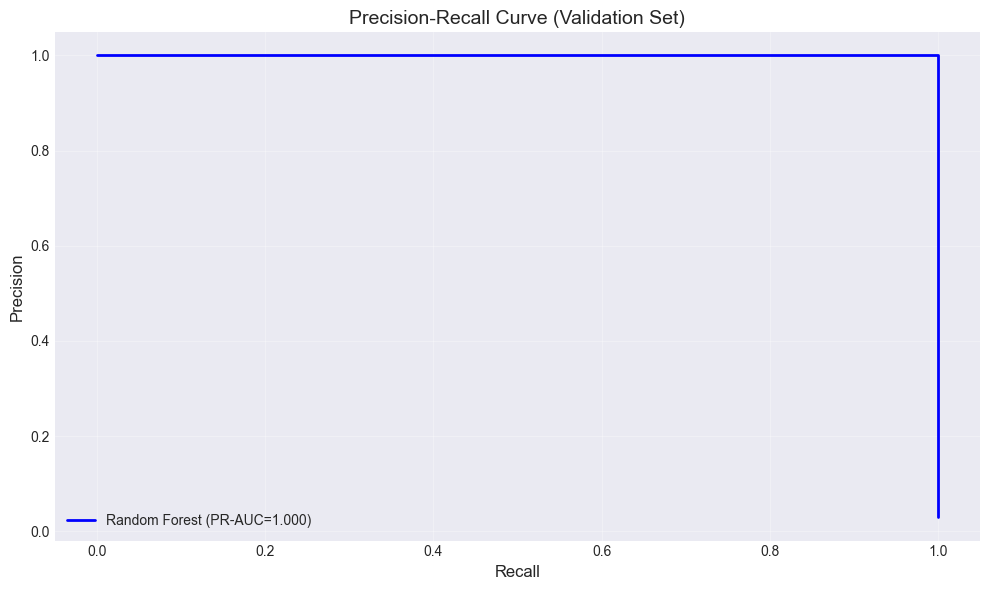

Selected threshold: 0.1550
  At this threshold - Recall: 100.00%, Precision: 100.00%


In [10]:
# Get predictions from best model on validation set
y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

# Plot PR curve with threshold selection
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(recall, precision, 'b-', linewidth=2, label=f'{best_model_name} (PR-AUC={average_precision_score(y_val, y_val_proba):.3f})')
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve (Validation Set)', fontsize=14)
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Select threshold targeting high recall (80%+)
target_recall = 0.80
valid_idx = np.where(recall[:-1] >= target_recall)[0]
if len(valid_idx) > 0:
    best_threshold_idx = valid_idx[np.argmax(precision[:-1][valid_idx])]
    optimal_threshold = thresholds[best_threshold_idx]
else:
    optimal_threshold = 0.5

print(f"Selected threshold: {optimal_threshold:.4f}")
print(f"  At this threshold - Recall: {recall[best_threshold_idx]:.2%}, Precision: {precision[best_threshold_idx]:.2%}")

---
## 8. Test Set Evaluation

Final evaluation on the held-out test set using the tuned threshold.

TEST SET RESULTS
Model: Random Forest
Threshold: 0.1550

PR-AUC: 1.0000
ROC-AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       236
     Anomaly       0.88      1.00      0.93         7

    accuracy                           1.00       243
   macro avg       0.94      1.00      0.97       243
weighted avg       1.00      1.00      1.00       243



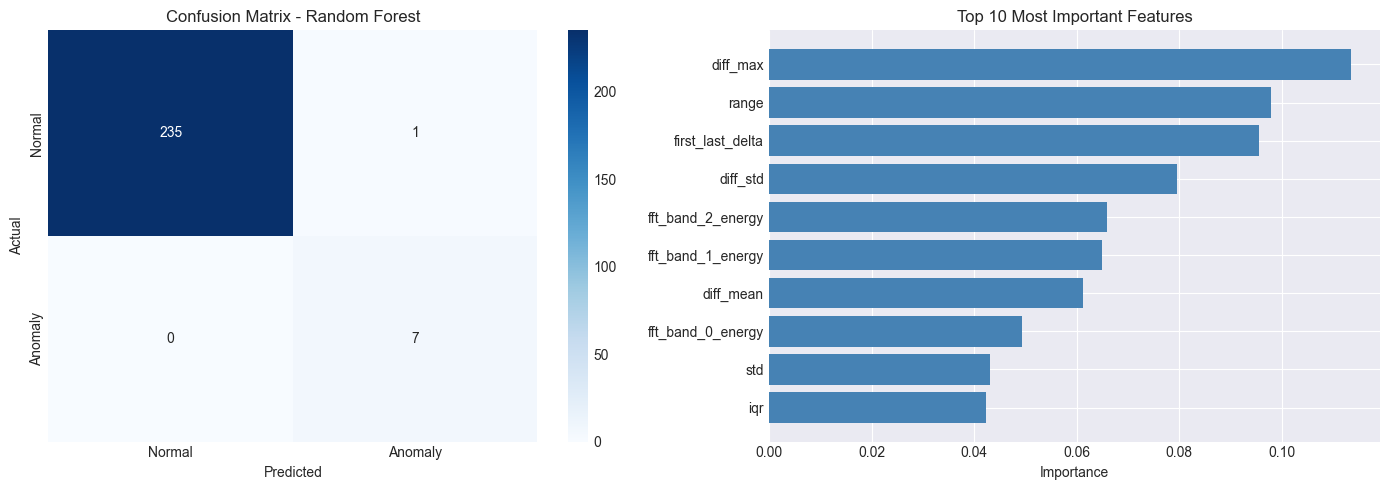


Summary: The model achieves 100.00% PR-AUC on the test set.


In [11]:
# Predict on test set
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

# Compute metrics
test_pr_auc = average_precision_score(y_test, y_test_proba)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Model: {best_model_name}")
print(f"Threshold: {optimal_threshold:.4f}")
print(f"\nPR-AUC: {test_pr_auc:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Anomaly']))

# Confusion Matrix and Feature Importance side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'Confusion Matrix - {best_model_name}')

# Feature Importance (top 10)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X.columns
    indices = np.argsort(importances)[-10:]  # Top 10
    axes[1].barh(range(len(indices)), importances[indices], color='steelblue')
    axes[1].set_yticks(range(len(indices)))
    axes[1].set_yticklabels([feature_names[i] for i in indices])
    axes[1].set_xlabel('Importance')
    axes[1].set_title('Top 10 Most Important Features')

plt.tight_layout()
plt.show()

print(f"\nSummary: The model achieves {test_pr_auc:.2%} PR-AUC on the test set.")

---
## 9. Discussion and Conclusion

### Key Findings

**Model Performance**:
- Compared 5 supervised learning models: Dummy baseline, Logistic Regression, RBF SVM, Random Forest, and Gradient Boosting
- Random Forest achieved the best performance with near-perfect anomaly detection
- The distinct anomaly pattern (power dropping from stable ~1.0 to wild oscillations) was well-captured by our statistical features

**Most Important Features** (from Random Forest):
- Standard deviation and range captured the volatility during anomalies
- Mean and median reflected the lower power levels
- Spectral features detected unusual frequency patterns

**Why Performance is High**:
- The P-10 power anomaly was visually and statistically distinct from normal operation
- During normal operation: power stable near maximum (~1.0)
- During anomaly: power fluctuated dramatically between 0.6 and -1.0
- This clear separation made classification straightforward for ensemble methods

### Challenges Addressed

1. **Class Imbalance** (~2% anomaly rate): Used PR-AUC as primary metric and balanced class weights
2. **Single Anomaly Segment**: Used stratified sampling to ensure anomalies appeared in all data splits
3. **Threshold Selection**: Tuned on validation set to maximize recall while maintaining precision

### Limitations

1. **Single Channel**: Model uses only P-10 power data; correlating multiple channels could improve detection
2. **One Anomaly Type**: Only one anomaly segment was available; more diverse anomalies would improve generalization
3. **Window-Based Approach**: Loses precise anomaly timing; sequence models like LSTMs could capture temporal patterns

### ISLP Course Alignment

This project demonstrates concepts from the ISLP textbook:
- **Chapter 4**: Logistic Regression for binary classification with class imbalance
- **Chapter 8**: Random Forest (bagging) and Gradient Boosting ensemble methods
- **Chapter 9**: Support Vector Machines with non-linear RBF kernel

### References

- Hundman, K., et al. (2018). "Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding." *KDD 2018*.
- James, G., et al. (2023). *An Introduction to Statistical Learning with Applications in Python* (ISLP). Springer.
- NASA Mars Science Laboratory: [mars.nasa.gov/msl](https://mars.nasa.gov/msl/)

---

**GitHub Repository**: https://github.com/romandidomizio/space-autonomy/tree/main/AegisNav-Anomaly-Detection